<a href="https://colab.research.google.com/github/akitim/comptech-winter-school-2022_covid19-prediction/blob/main/Comptech_val_eng_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install httpx

     |████████████████████████████████| 84 kB 2.5 MB/s 
     |████████████████████████████████| 68 kB 5.7 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 79 kB 8.2 MB/s 


In [2]:
import pandas as pd
import itertools
from scipy.signal import savgol_filter
from tqdm.notebook import tqdm
import json
from collections import defaultdict
import pickle
from matplotlib import pyplot as plt
import pickle
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
import statsmodels.api as sm
from datetime import date, timedelta
import pickle
import httpx
import json
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def get_cases(days):
  data = httpx.get(f"https://storage.yandexcloud.net/covid-19/cases{
      ('_' + str(days)) if days != 0 else ''}.pickle").content
  return pickle.loads(data)

In [4]:
def get_lags(days):
  data = httpx.get(f"https://storage.yandexcloud.net/covid-19/lags{
      ('_' + str(days)) if days != 0 else ''}.json").content
  return json.loads(data)

In [5]:
def median_percentage_absolute_error(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true))

In [43]:
def get_columns(country, top_3_countries, num_features):
  first = [f"{country}_{i}" for i in range(1, 31)]
  second = []
  for c, _ in top_3_countries:
    for i in range(1, num_features + 1):  
      second.append(f"{c}_{i}")
  second.append('y')
  return first + second


def get_predict(country, lags, need_predict, cases_all, use_filter=True, num_features=30):

  field_name = ("filtered_" if use_filter else "") + "history"
  threshold = date(year=2021, month=1, day=1)

  # PREPARE TRAIN DATA
  a = cases_all[country][field_name] #случаи по стране cглаженные или нет
  a = a[a.index >= threshold] #отсечение - берем даты после 01.01.2021
  df_list = []
  top_3_countries = [
    i for i in sorted(lags[country].items(),
                        key=lambda x: x[1]["similarity"]
                      ) if -i[1]["lag"] > need_predict
    ][-3:] #топ-3 страны с максимальной корреляцией

  for window in range(num_features, (a.index[-1] - threshold).days): # window проходит значения от кол-ва пр-ков до кол-ва дней в рассм. cases
    this_row = list(a[window - num_features : window].values)
    y = a[window]

    for country_similar, info in top_3_countries:

      b = cases_all[country_similar][field_name]
      this_row += list(b[b.index > threshold - timedelta(days=-info["lag"])]
                       [window - num_features : window].values)

    this_row.append(y)
    df_list.append(this_row)

  df = pd.DataFrame(df_list, columns=get_columns(country, top_3_countries, num_features))

  # FIT
  X = sm.add_constant(df.drop('y', axis=1))
  y = df['y']
  model = sm.OLS(y, X).fit()

  # PREDICT
  predicted = []
  for i in range(0, need_predict):
    if i >= num_features:
      p = [1.0] + predicted[-num_features:]
    else:
      p = [1.0] + list(cases_all["Russia"][field_name].iloc[-num_features + i:].values) + predicted
    for c, info in top_3_countries:
      from_ind = -num_features + info["lag"] + i
      to_ind = info["lag"] + i
      p += list(cases_all[c][field_name].iloc[from_ind: to_ind])
    predicted.append(model.predict(p)[0])
  
  return np.array(predicted)

In [7]:
days = [30, 60, 90]

In [8]:
cases_30, cases_60, cases_90 = (get_cases(i) for i in days)

In [9]:
lags_30, lags_60, lags_90 = (get_lags(i) for i in days)

In [10]:
df_dict = {30: (cases_30, lags_30), 60: (cases_60, lags_60)}#, 90:(cases_90, lags_90)}

In [39]:
# cases_30['Russia'].items()
# a = cases_30['Russia']['filtered_history']
# a = a[a.index >= date(year=2021, month=1, day=1)]
# (a.index[-1] - date(year=2021, month=1, day=1)).days
# a.index[0]\

need_predict = 20
country = 'Namibia'
lags = lags_60

# top_3_countries = [
#     i for i in sorted(lags[country].items(),
#                         key=lambda x: x[1]["similarity"]
#                       ) if -i[1]["lag"] > need_predict
#     ][-3:]
# top_3_countries
l = np.asarray([[1, 2], [4, 5]])
pd.DataFrame(l)

,0,1
0,1,2
1,4,5


In [41]:
def validator_dict(model, df_dict, use_filter=True):
    result = {}
    # mape = []
    mdape = []
    
    for days, lst in df_dict.items():

      cases, lags = lst
      for country in lags.keys():
          
       if country == "Russia":
        y_true = cases[country][f"{'filtered_' if use_filter else ''}validate"]
        y_pred = model(country, lags, days, cases, use_filter)
        return y_true, y_pred

        if any(y_pred != y_pred) or any(y_pred == 0) or any(y_true == 0):
            continue
        
        # mape.append(mean_absolute_percentage_error(y_true, y_pred)) 
        mdape.append(median_percentage_absolute_error(y_true, y_pred)) 
        
      result[str(days) + ' days'] = np.array(mdape).mean()

    return result

In [42]:
true_, pred_ = validator_dict(get_predict, df_dict, True)

,Russia_1,Russia_2,Russia_3,Russia_4,Russia_5,Russia_6,Russia_7,Russia_8,Russia_9,Russia_10,Russia_11,Russia_12,Russia_13,Russia_14,Russia_15,Russia_16,Russia_17,Russia_18,Russia_19,Russia_20,Russia_21,Russia_22,Russia_23,Russia_24,Russia_25,Russia_26,Russia_27,Russia_28,Russia_29,Russia_30,Iran_1,Iran_2,Iran_3,Iran_4,Iran_5,Iran_6,Iran_7,Iran_8,Iran_9,Iran_10,...,Guatemala_22,Guatemala_23,Guatemala_24,Guatemala_25,Guatemala_26,Guatemala_27,Guatemala_28,Guatemala_29,Guatemala_30,Costa Rica_1,Costa Rica_2,Costa Rica_3,Costa Rica_4,Costa Rica_5,Costa Rica_6,Costa Rica_7,Costa Rica_8,Costa Rica_9,Costa Rica_10,Costa Rica_11,Costa Rica_12,Costa Rica_13,Costa Rica_14,Costa Rica_15,Costa Rica_16,Costa Rica_17,Costa Rica_18,Costa Rica_19,Costa Rica_20,Costa Rica_21,Costa Rica_22,Costa Rica_23,Costa Rica_24,Costa Rica_25,Costa Rica_26,Costa Rica_27,Costa Rica_28,Costa Rica_29,Costa Rica_30,y
0,26061.352013,25933.175134,25676.109312,25391.192258,25142.862081,24918.890938,24685.737480,24459.728737,24194.186595,23878.450724,23533.835897,23224.250017,22930.414551,22619.546037,22347.781263,22097.463340,21810.024712,21470.399284,21217.091146,20963.186459,20721.185259,20483.029672,20241.807765,19959.329679,19663.210469,19421.898186,19172.988584,18913.156833,18612.604295,18279.647399,4150.161091,4255.701012,4351.255045,4472.021042,4564.132234,4682.538834,4784.393486,4927.023104,5080.924506,5265.738273,...,471.258760,469.471562,481.195882,486.846067,497.817935,513.922105,497.777436,479.804661,477.465220,1034.114929,1047.577544,989.911142,953.586310,961.718703,949.288432,945.275635,979.961381,1007.060749,967.101882,946.667467,958.309882,950.352284,959.829441,999.193345,1029.331083,981.350268,952.584974,961.852296,956.057827,971.040635,1009.613219,1044.280482,1017.308297,992.705543,999.981132,995.002695,1002.986727,1034.746721,1070.120931,17981.615008
1,25933.175134,25676.109312,25391.192258,25142.862081,24918.890938,24685.737480,24459.728737,24194.186595,23878.450724,23533.835897,23224.250017,22930.414551,22619.546037,22347.781263,22097.463340,21810.024712,21470.399284,21217.091146,20963.186459,20721.185259,20483.029672,20241.807765,19959.329679,19663.210469,19421.898186,19172.988584,18913.156833,18612.604295,18279.647399,17981.615008,4255.701012,4351.255045,4472.021042,4564.132234,4682.538834,4784.393486,4927.023104,5080.924506,5265.738273,5430.321049,...,469.471562,481.195882,486.846067,497.817935,513.922105,497.777436,479.804661,477.465220,476.886430,1047.577544,989.911142,953.586310,961.718703,949.288432,945.275635,979.961381,1007.060749,967.101882,946.667467,958.309882,950.352284,959.829441,999.193345,1029.331083,981.350268,952.584974,961.852296,956.057827,971.040635,1009.613219,1044.280482,1017.308297,992.705543,999.981132,995.002695,1002.986727,1034.746721,1070.120931,1031.291943,17680.085121
2,25676.109312,25391.192258,25142.862081,24918.890938,24685.737480,24459.728737,24194.186595,23878.450724,23533.835897,23224.250017,22930.414551,22619.546037,22347.781263,22097.463340,21810.024712,21470.399284,21217.091146,20963.186459,20721.185259,20483.029672,20241.807765,19959.329679,19663.210469,19421.898186,19172.988584,18913.156833,18612.604295,18279.647399,17981.615008,17680.085121,4351.255045,4472.021042,4564.132234,4682.538834,4784.393486,4927.023104,5080.924506,5265.738273,5430.321049,5589.732270,...,481.195882,486.846067,497.817935,513.922105,497.777436,479.804661,477.465220,476.886430,483.018256,989.911142,953.586310,961.718703,949.288432,945.275635,979.961381,1007.060749,967.101882,946.667467,958.309882,950.352284,959.829441,999.193345,1029.331083,981.350268,952.584974,961.852296,956.057827,971.040635,1009.613219,1044.280482,1017.308297,992.705543,999.981132,995.002695,1002.986727,1034.746721,1070.120931,1031.291943,1005.926793,17341.508120
3,25391.192258,25142.862081,24918.890938,24685.737480,24459.728737,24194.186595,23878.450724,23533.835897,23224.250017,22930.414551,22619.546037,22347.781263,22097.463340,21810.024712,21470.399284,21

In [14]:
%matplotlib inline

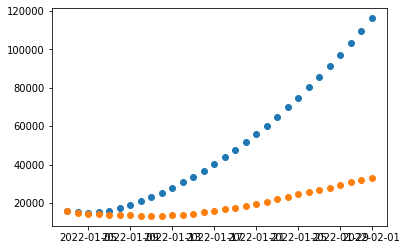

In [15]:
from matplotlib import pyplot as plt
plt.scatter(true_.index, true_.values)
plt.scatter(true_.index, pred_)

In [16]:
validator_dict(get_predict, df_dict, True)

(Last_Update
 2022-01-03     15903.186074
 2022-01-04     15375.798342
 2022-01-05     15097.706064
 2022-01-06     15199.817029
 2022-01-07     15708.974767
 2022-01-08     17229.301400
 2022-01-09     18958.113152
 2022-01-10     20895.410024
 2022-01-11     23041.192015
 2022-01-12     25395.459127
 2022-01-13     27958.211358
 2022-01-14     30729.448709
 2022-01-15     33709.171180
 2022-01-16     36897.378771
 2022-01-17     40294.071481
 2022-01-18     43899.249311
 2022-01-19     47712.912261
 2022-01-20     51735.060331
 2022-01-21     55965.693521
 2022-01-22     60404.811830
 2022-01-23     65052.415259
 2022-01-24     69908.503808
 2022-01-25     74973.077477
 2022-01-26     80246.136266
 2022-01-27     85727.680174
 2022-01-28     91417.709203
 2022-01-29     97316.223351
 2022-01-30    103423.222618
 2022-01-31    109738.707006
 2022-02-01    116262.676513
 dtype: float64,
 array([15738.44763181, 15065.49219754, 14491.12777501, 14113.86076613,
        13891.29646748, 1374

In [17]:
early = [127297.73641993303, 132600.20483385914, 136619.37434922362, 140836.80730270335, 143737.04746894058, 142813.11085296664, 142630.53345246712, 143341.5066806572, 143076.48524371465, 146335.75887030794, 146210.0414530263,147364.13578195698, 150360.07855808048, 150905.0310396987, 149520.86527956236, 156450.18866885972, 156425.910736048, 160164.36502176864, 162606.36517775926, 169749.19835550373, 170366.17978586693, 171357.34940489975, 173582.94171802138,174031.0639300036, 177210.84705378467, 178115.14202578535, 181952.4384241183, 180652.69380222203, 181609.9641533312, 178259.66305531352]

In [18]:
cases = get_cases(0)
lags = get_lags(0)

In [19]:
predict = get_predict("Russia", lags, 30, cases)

In [20]:
len(a.values)

367

In [21]:
print(len(a.index), len(predict))

367 30


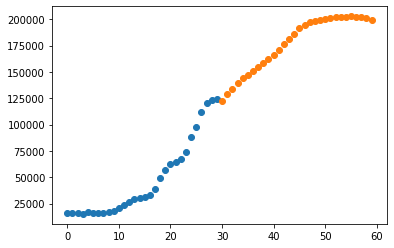

In [22]:
a = cases["Russia"]["history"].iloc[-30:]
plt.scatter(range(0, 30), list(a.values))
plt.scatter(range(30, 60), list(predict))
plt.show();

In [23]:
def get_predict(predict_country, lags, predict_days, cases, use_filter=False):
    predict = np.zeros(predict_days)
    weights = 0
    field_name = ("filtered_" if use_filter else "") + "history"
    mean_predict_country = cases[predict_country][field_name][-predict_days:].mean()

    for country, desc in lags[predict_country].items():
        days_lag = -desc["lag"]  # т.к. всегда отрицательная величина
        if days_lag <= predict_days:
            continue
        
        cases_prev_days = cases[country][field_name].iloc[-days_lag: -days_lag + predict_days]
        coef = (mean_predict_country / cases_prev_days.mean())
        weight = np.sqrt(desc["similarity"])
        case = cases_prev_days.values * coef * weight
        
        if len(case) == predict_days:
          weights += weight
          predict += case
    
    if weights != 0:
        return predict / weights
    else:
        return predict